Import libraries and useful functions. Code reused from week 4 exercises.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None, n_classes=10):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        labels=np.arange(n_classes),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

Load the CIFAR-10 dataset and split it into train, validation, calibration and test sets.

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# Load full training dataset (50,000 samples)
full_train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Split into train (40k), validation (5k) and calibration (10k) sets
train_size = 35000 # 35,000
valid_size = 5000 # 5,000
calib_size = 10000 # 10,000

train_set, valid_set, calib_set = torch.utils.data.random_split(
    full_train_set, [train_size, valid_size, calib_size]
)

# Test set remains unchanged
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
calib_loader = DataLoader(calib_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Map from class index to class name.
classes = {index: name for name, index in full_train_set.class_to_idx.items()}

In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.dataset.targets))} (unique labels: {set(train_set.dataset.targets)})")

print("\nValidation data")
print("Number of points:", len(valid_set))
x, y = next(iter(valid_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(valid_set.dataset.targets))} (unique labels: {set(valid_set.dataset.targets)})")

print("\nCalibration data")
print("Number of points:", len(calib_set))
x, y = next(iter(calib_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(calib_set.dataset.targets))} (unique labels: {set(calib_set.dataset.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 35000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Validation data
Number of points: 5000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Calibration data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


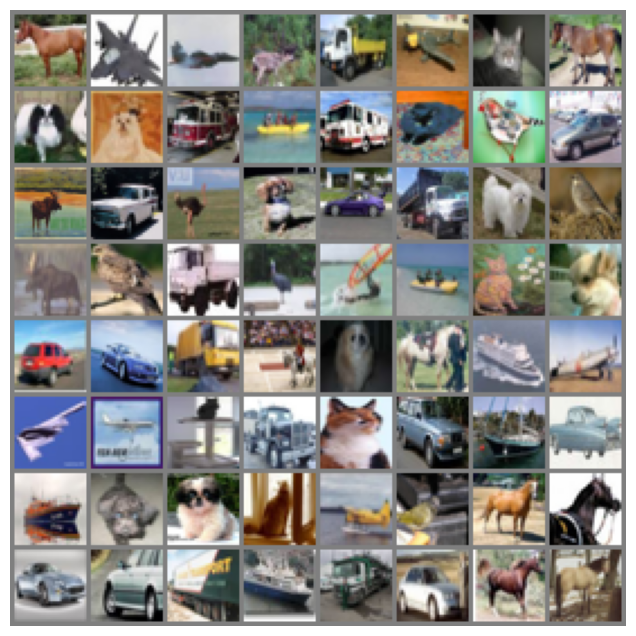

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

Define model architecture and forward pass.

In [5]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.activation_fn = nn.ReLU

        self.net = nn.Sequential(
            # CNN
            nn.Conv2d(3, 32, 5),
            self.activation_fn(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            self.activation_fn(),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Flatten(),

            # FFNN
            nn.LazyLinear(128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)
    


#model = Model(n_classes)
#device = torch.device('cpu')  
#model.to(device)
#print(model)

Initialize grid for grid search and the loss function.

In [6]:
from itertools import product

# Define grid
param_grid = {
    "optimizer": ["Adam", "SGD"],
    "lr": [1e-1, 1e-3, 1e-5]
    }

# Create iterable list of param combinations
keys = param_grid.keys()
values = param_grid.values()

combinations = list(product(*values))
print(combinations)

for combo in combinations:
    print(combo[0])

# Define loss function
loss_fn = nn.CrossEntropyLoss()  

[('Adam', 0.1), ('Adam', 0.001), ('Adam', 1e-05), ('SGD', 0.1), ('SGD', 0.001), ('SGD', 1e-05)]
Adam
Adam
Adam
SGD
SGD
SGD


Perform grid search cross-validation.

In [7]:
num_epochs = 8 ## train model for longer
accuracy_every_steps = 500

best_accuracy = -np.inf
best_param = []

train_accuracies = []

# Loop over parameter combinations
for combo in combinations:
    model = Model(n_classes)
    device = torch.device('cpu')  
    model.to(device)
    model.train()

    step = 0
    valid_accuracies = []

    # Retrieve learning rate
    lr = combo[1]
    
    # Retrive optimizer
    if combo[0] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr) 
        
    # Train model
    for epoch in range(num_epochs):
        
        train_accuracies_batches = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass, compute gradients, perform one training step.

            # Compute outputs
            output = model(inputs)

            # Compute loss
            loss = loss_fn(output, targets)

            # Zero gradients
            optimizer.zero_grad()

            # Backprop
            loss.backward()

            # One step of gradient descent
            optimizer.step()
            
            # Increment step counter
            step += 1
            
            # Compute accuracy.
            predictions = output.max(1)[1]
            train_accuracies_batches.append(accuracy(targets, predictions))
            
            # Compute trian accuracy every  steps.
            if step % accuracy_every_steps == 0:
                train_accuracies.append(np.mean(train_accuracies_batches))
                print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")

    # Perfrom cross validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
                
            # Forward pass, compute gradients, perform one training step.

            # Compute outputs
            output = model(inputs)
                
            # Increment step counter
            step += 1
                
            # Compute accuracy.
            predictions = output.max(1)[1]
            valid_accuracies.append(accuracy(targets, predictions))

        mean_valid_accuracy = np.mean(valid_accuracies)
        print(f"Validation accuracy for combo {combo}: {mean_valid_accuracy}")

        if mean_valid_accuracy > best_accuracy:
            best_accuracy = mean_valid_accuracy
            best_param = combo


print("Finished training.")
print("Best params:", best_param)
print("Best accuract:", best_accuracy)

Step 500     training accuracy: 0.097125
Step 1000    training accuracy: 0.09809602649006623
Step 1500    training accuracy: 0.0980603448275862
Step 2000    training accuracy: 0.09753655988857939
Step 2500    training accuracy: 0.0985576923076923
Step 3000    training accuracy: 0.09941037735849056
Step 3500    training accuracy: 0.09962729357798165
Step 4000    training accuracy: 0.0960343567251462
Validation accuracy for combo ('Adam', 0.1): 0.10225474683544304
Step 500     training accuracy: 0.4041875
Step 1000    training accuracy: 0.5614997240618101
Step 1500    training accuracy: 0.6408559113300493
Step 2000    training accuracy: 0.686716573816156
Step 2500    training accuracy: 0.7294170673076923
Step 3000    training accuracy: 0.7683372641509434
Step 3500    training accuracy: 0.8046875
Step 4000    training accuracy: 0.8399122807017544
Validation accuracy for combo ('Adam', 0.001): 0.6861155063291139
Step 500     training accuracy: 0.1763125
Step 1000    training accuracy: 0.29

Train the model using best parameters.

In [13]:
model = Model(n_classes)
device = torch.device('cpu')  
model.to(device)
model.train()

lr = best_param[1]
if best_param[0] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()  


In [14]:
num_epochs = 8 ## train model for longer
accuracy_every_steps = 500

step = 0

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.

        # Compute outputs
        output = model(inputs)

        # Compute loss
        loss = loss_fn(output, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # One step of gradient descent
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        # Validate every `validation_every_steps` steps.
        if step % accuracy_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")


print("Finished training.")

Step 500     training accuracy: 0.40821875
Step 1000    training accuracy: 0.5603269867549668
Step 1500    training accuracy: 0.6427801724137931
Step 2000    training accuracy: 0.689066852367688
Step 2500    training accuracy: 0.7338741987179487
Step 3000    training accuracy: 0.7734669811320755
Step 3500    training accuracy: 0.8120699541284404
Step 4000    training accuracy: 0.8436586257309941
Finished training.


In [15]:
def conformal_prediction(calib_loader, model):
    true_label_prob = []
    alpha = 0.1

    with torch.no_grad():
        for inputs, targets in calib_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)

            # Compute softmax probabilities
            probs = torch.softmax(output, dim=1)

            # Add softmax probabilities for true labels into a list
            for sample in range(len(probs)):
                true_label_prob.append(probs[sample][targets[sample].item()])

        # Compute non-conformity scores
        non_comf_scores = np.zeros(len(true_label_prob))
        for i in range(len(true_label_prob)):
            non_comf_scores[i] = 1 - true_label_prob[i]
        non_comf_scores.sort()
            
        # Compute threshold
        threshold_index = np.ceil((len(non_comf_scores) + 1) * (1 - alpha)) - 1
        threshold = non_comf_scores[int(threshold_index)]
        print(threshold)

    return threshold
    
thresh = conformal_prediction(calib_loader, model)

0.9603832960128784


Evaluate model performance on test set.

In [ ]:
# Evaluate test set
calibration_plot = []
confusion_matrix = np.zeros((n_classes, n_classes))

with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)

        probs = torch.softmax(output, dim=1)

        # Prediction set per batch
        pred_set = []

        # Add classes to prediction set
        # Loop over batch len = 64
        for i in range(len(probs)):
            # Extract largest probability and predicted class
            predicted_class = probs[i].argmax().item()
            confidence = probs[i].max().item()

            # Add to list as tuple (confidence, correct_class?)
            if predicted_class == targets[i].item():
                calibration_plot.append((confidence, 1))
            else:
                calibration_plot.append((confidence, 0))

            # Loop over individual probabilities len = 10
            for j in range(len(probs[i])):
                # Compute prediction sets ----> maybe change structure of pred sets for clarity if we have the time
                if probs[i][j] >= 1 - thresh:
                    pred_set.append(j)

            # Show prediction sets
            #print("possible classes", pred_set)
            #print("true class", targets[i].item())
            pred_set = []

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.683


Prepare calibration plot bins.

In [ ]:
# Create matrix with confidence bins
n_rows = 11
calibration_matrix = [[] for _ in range(n_rows)]

# Create bins
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)

# Split confidence and hit? into the respective bins
for i in range(len(calibration_plot)):
    confidence = calibration_plot[i][0]
    hit = calibration_plot[i][1]

    # Get index of respective bin
    bin_index = np.digitize(confidence, bins) - 1

    # Add tuple to list
    calibration_matrix[bin_index].append((confidence, hit))

print(calibration_matrix)


[[], [(0.1839345544576645, 0), (0.18064728379249573, 0)], [(0.25464946031570435, 0), (0.23822268843650818, 0), (0.29716095328330994, 1), (0.26672089099884033, 0), (0.26467543840408325, 0), (0.2708894610404968, 0), (0.24999678134918213, 0), (0.2858496904373169, 1), (0.270822674036026, 0), (0.29142677783966064, 0), (0.2733125388622284, 1), (0.25766104459762573, 0), (0.2910984456539154, 1), (0.24055306613445282, 1), (0.26543253660202026, 0), (0.2632894217967987, 0), (0.26476743817329407, 1), (0.24901564419269562, 0), (0.28699159622192383, 1), (0.2960519790649414, 0), (0.2998020648956299, 0), (0.22886909544467926, 0), (0.2159413993358612, 0), (0.29255759716033936, 0), (0.2673671841621399, 1), (0.29825350642204285, 0), (0.29404687881469727, 0), (0.2389420121908188, 1), (0.23162682354450226, 0), (0.29315701127052307, 0), (0.28041785955429077, 0), (0.2941698729991913, 0), (0.29703912138938904, 0), (0.2621510922908783, 0), (0.24794414639472961, 0), (0.29333382844924927, 0), (0.2887442111968994

Prepare data for calibration curve.

In [90]:
x, y = [], []
sum, count = 0, 0

# Loop through bins
for row in calibration_matrix:
    # Check if bin non-empty
    if len(row) != 0:
        # Iterate through bin and compute average confidence and accuracy
        for item in row:
            sum += item[0]
            count += item[1]
        
        # Add to x and y lists
        x.append(sum / len(row))
        y.append(count / len(row))

        sum, count = 0, 0

#print(x)
#print(y)

Plot the calibration curve.

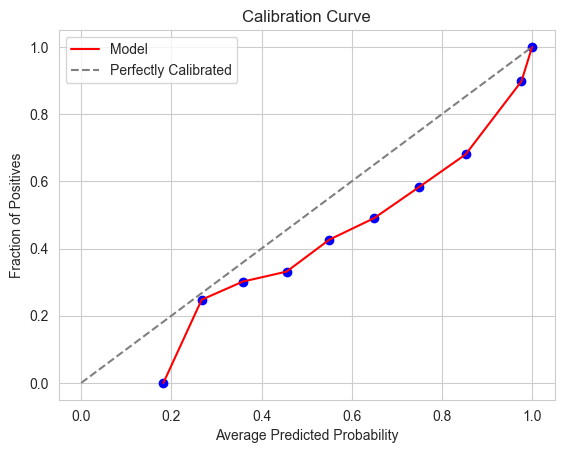

In [ ]:
import matplotlib.pyplot as plt
# Perfectly calibrated line
x_perf = np.linspace(0, 1, 11)
y_perf = x_perf

# Plot calibration curve
plt.plot(x, y, label="Model", color='red')
plt.scatter(x, y, color='blue')
plt.plot(x_perf, y_perf, label="Perfectly Calibrated", linestyle='--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Average Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(loc="upper left")
plt.show()

UPDATE PLOTS TO INCLUDE CONFORMAL PREDICTION

Plot confusion matrix for test set.

In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Plot per class accuracy of predictions.

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()